# Vision part of the Mobile Robotics project

## Notes about the project and innput advancement

Dimensions of the thymio : 11 cm x 11.2 cm x 5.3 cm (https://wiki.thymio.org/fr:thymiospecifications)
I'll then choose 12-cm side squares for the start and end of the thymio, respectively green and blue.




## Imports

In [74]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

### Loading image

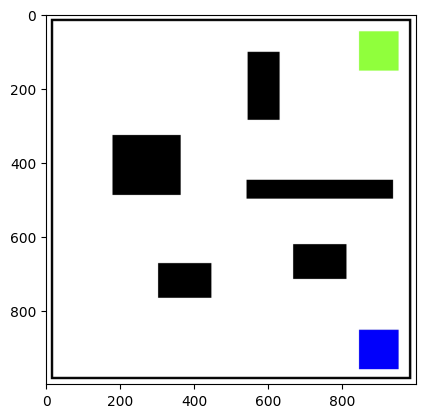

In [90]:
# Load the image
image = cv2.imread('map_mobilerobotics.jpeg')

#Resize this image to 1mx1m
image = cv2.resize(image, (1000, 1000))

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.show()

## Preprocessing

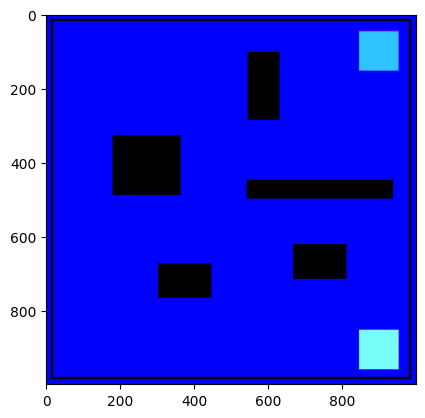

In [91]:
# Convert the image to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Display the image
plt.imshow(hsv)
plt.show()

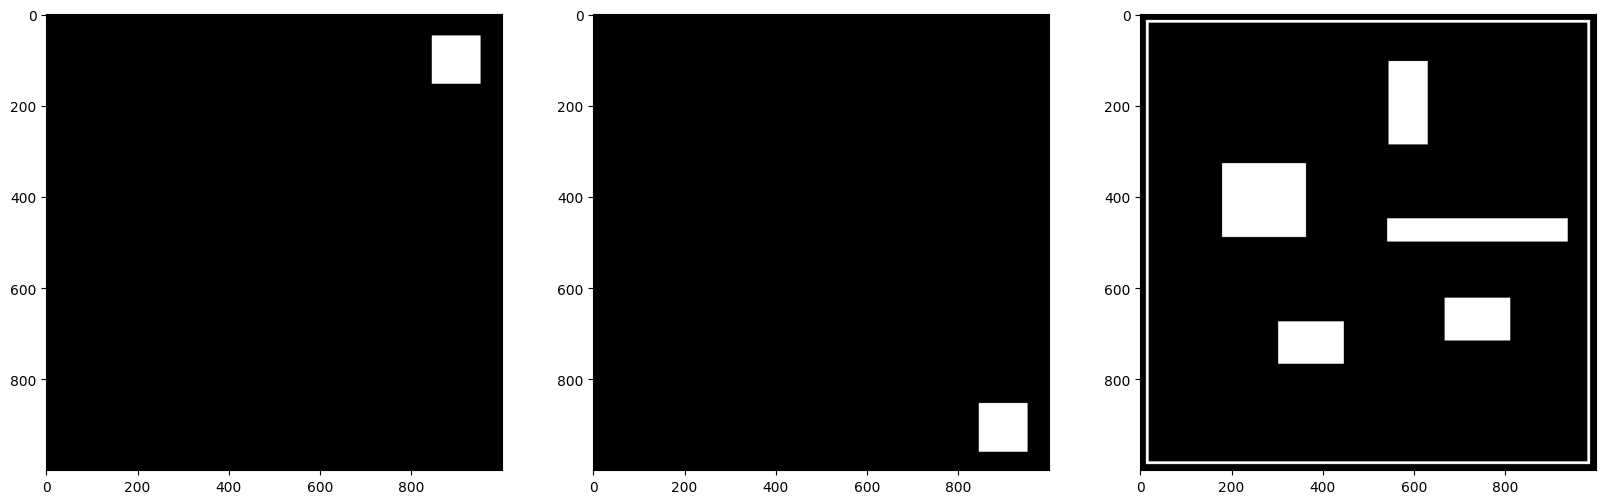

In [111]:
# Define color ranges for green squares
green_lower = np.array([35, 100, 100])
green_upper = np.array([85, 255, 255])
green_mask = cv2.inRange(hsv, green_lower, green_upper)

# Define color ranges for blue squares
blue_lower = np.array([100, 100, 100])
blue_upper = np.array([140, 255, 255])
blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

# Define color ranges for black squares or rectangles
black_lower = np.array([0, 0, 0])
black_upper = np.array([180, 255, 30])
black_mask = cv2.inRange(hsv, black_lower, black_upper)

#display the 3 masks
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(green_mask, cmap="gray")
plt.subplot(132)
plt.imshow(blue_mask, cmap="gray")
plt.subplot(133)
plt.imshow(black_mask, cmap="gray")
plt.show()


In [101]:
# Find contours for each colour
green_contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blue_contours, _ = cv2.findContours(blue_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
black_contours, _ = cv2.findContours(black_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [108]:
# Draw contours on the original image

cv2.drawContours(image, black_contours, -1, (0, 255, 255), 3) # Red color for black squares
cv2.drawContours(image, green_contours, -1, (255, 105, 180), 3) # Pink color for green squares
cv2.drawContours(image, blue_contours, -1, (255, 0, 0), 3) # Yellow color for blue squares


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

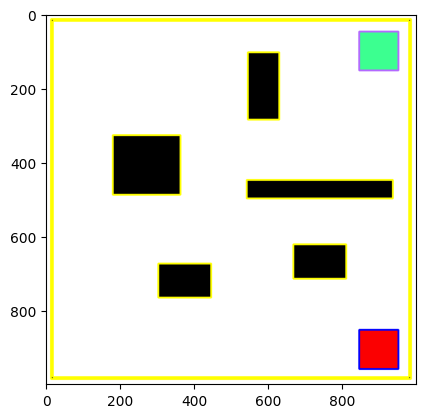

In [109]:
# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [110]:
for cnt in blue_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Blue square found at coordinates: {x}, {y}')

for cnt in green_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Green square found at coordinates: {x}, {y}')

for cnt in black_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Black square found at coordinates: {x}, {y}')


Blue square found at coordinates: 846, 853
Green square found at coordinates: 846, 47
Black square found at coordinates: 13, 13
Black square found at coordinates: 18, 18
Black square found at coordinates: 303, 674
Black square found at coordinates: 668, 622
Black square found at coordinates: 542, 448
Black square found at coordinates: 180, 327
Black square found at coordinates: 545, 103


## Displaying the video

In [40]:


# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture(1)

# Check if camera opened successfully
if not cap.isOpened(): 
    print("Error opening video stream or file")

# Read and display each frame of the video
while True:
    ret, frame = cap.read()

    if ret:
        # Display the resulting frame
        #median = cv2.medianBlur(frame,1) #use a median blur filter
        gauss = cv2.GaussianBlur(frame,(1111,1111),11) #use the gaussian filter
        cv2.imshow('Frame', gauss) #change varibal here

        # Press 'q' on the keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

        time.sleep(0.01)  # Control frame rate (optional)

    else:
        break


# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

print("Done displaying the video")

## Filtering